## Aligning PPG To ECG

In [1]:
import numpy
import matplotlib.pyplot as plt
import os
fps = 30.323427803

Here we refer to the time window as the frame. Each frame is 0.033 sec front and back (so 0.67 total)

First we create a class called RRIT (RR interval). It contains one rr interval value and its corresponding time in a signal

In [2]:
class RRIT:
    def __init__(self, time, value):
        self.value = value
        self.time = time
    def __str__(self):
        return '{0:<6.2f} {1:<4}'.format(self.time, self.value)

Next, we define a class extending list holding many RRIT

In [17]:
def withinRange(begin, endExclude, value):
    return begin <= value and value < endExclude
class RRSignal(list):
    
    def __init__(self, rrValueList, name, color, threshold):
        list.__init__(self)
        self.constructRRITList(rrValueList)
        self.name = name
        self.color = color
        self.threshold = threshold
    def getRRITList(self):
        return [RRIT.value for RRIT in self]
    def getTimeList(self):
        return [RRIT.time for RRIT in self]
    def duration(self, beginIndex=-1, endIndex=-1):
        beginT = self[beginIndex].time if withinRange(0, len(self), beginIndex) else self[0].time
        endT = self[endIndex-1].time if withinRange(0, len(self), endIndex-1) else self[-1].time
        return endT - beginT
    #create a corresponding RRIT list from the rr value list
    #rr value in ms; time in second
    def constructRRITList(self, rrValueList):
        firstRRValue = round(rrValueList[0]*1000)
        self.append(RRIT(0, firstRRValue))
        pastTime = 0
        for i in range(1, len(rrValueList)):
            curTime = pastTime + rrValueList[i-1]
            curRRValue = round(rrValueList[i]*1000)
            curRRIT = RRIT(curTime, curRRValue)
            self.append(curRRIT)
            pastTime = curTime
    def interpolate(self, targetTime, indexOffset=0):
        targetTime = self[indexOffset].time + targetTime
        #targetTime is not in range of array
        if targetTime < self[0].time or self[-1].time < targetTime:
            return -1
        #if targetTime is in range, locate its position on this set
        leftIndex = -1
        for i in range(len(self)):
            if targetTime < self[i].time:
                leftIndex = i-1
                break
        leftRRIT = self[leftIndex]
        rightRRIT = self[leftIndex+1]
        slope = (rightRRIT.value - leftRRIT.value) / (rightRRIT.time - leftRRIT.time)
        deltaTime = targetTime - leftRRIT.time
        deltaValue = deltaTime * slope
        return leftRRIT.value + deltaValue
    def align(ecg, ppg):
        minAlignmentDistance = 100000000
        bestFitTime = None
        for i in range(len(ecg)):
            if ppg.duration() > ecg.duration(beginIndex=i):
                break
            totalDistance = 0
            for ppgRRIT in ppg:
                interpolatedValue = ecg.interpolate(ppgRRIT.time, indexOffset=i)
                totalDistance += abs(interpolatedValue - ppgRRIT.value)
            print(totalDistance)
            if totalDistance < minAlignmentDistance:
                minAlignmentDistance = totalDistance
                bestFitTime = ecg[i].time
        return bestFitTime
    
        
        

In [18]:
l = analyzeVideoAndObtainBestRedRRInterval("/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt")
ppg = RRSignal(l, "name", 'red', '15')
RRSignal.align(ecg1, ppg)

5464.080027727101
5449.6531462123085
5581.082901607406
5793.107598795276
5999.4768776276505
6102.692109288871
6274.735595188957
6452.504656880489
6434.823593503876
6398.511626233578
6413.583044971569
6582.140757612159
6788.307948568109
6864.894471531123
6964.420436145857
7209.741959694757
7508.305860711761
7705.974537004057
7777.867091746029
7914.3174555018495
8231.04674908228
8537.737544846615
8548.696220207376
8469.351833645354
8572.258355955391
8827.49106248332
8984.725177589098
8922.082993337059
8905.066083751022
9076.017823893771
9131.628419819624
9162.522347611439
9361.084345621446
9689.378405159723
9920.522227604608
9889.073821651718
9854.564889455543
9950.926762585927
9776.737994084264
9470.10035353329
9477.406467150297
9622.606809970222
9636.984158133117
9557.660130649721
9571.777461778549
9667.999608222146
9866.592535669432
9905.229540104254
9797.057769835399
9689.411944864696
9626.47908511076
9544.05649079269
9368.80725545546
9231.366284141463
9305.853645715451
9532.38366789

0.833

In [19]:
len(ecg1)

667

In [20]:
def convertStrLToSecFloatL(array):
    for i in range(len(array)):
        array[i] = float(array[i])/1000.0
    return array

f = open('/home/mong/Desktop/map/map/videos/15012301_GIO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-1]
rrData = rrSection.split('\n')
#get rid of header
ecg1 = rrData[1:-1]
ecg1 = convertStrLToSecFloatL (ecg1)
ecg1 = RRSignal(ecg1, '15012301_GIO.hrm', 'n/a', 'n/a')

#second hrm file
f = open('/home/mong/Desktop/map/map/videos/15012301_GLO.hrm', 'r')
inputSectionList = f.read().split('\n\n')
rrSection = inputSectionList[-2]
rrData = rrSection.split('\n')
#get rid of header
ecg2 = rrData[1:]
ecg2 = convertStrLToSecFloatL (ecg2)
ecg2 = RRSignal(ecg2, '15012301_GLO.hrm', 'n/a', 'n/a')

In [21]:
def readFromFile(fileName):
    l =numpy.loadtxt(fileName)
    return l[0], l[1], l[2]

In [22]:
def detectPeak(colorL, frameThreshold):
    peakL = list()
    colorlistLen = len(colorL)
    for i in range(1, colorlistLen-1):
        biggerThanPrevious = colorL[i] > colorL[i-1]
        biggerThanAfter = colorL[i] > colorL[i+1]
        #if it is a local maximum, then check if it is a RR peak by comparing its maxima interval to frameThreshold
        if biggerThanPrevious and biggerThanAfter:
            for k in range(2, frameThreshold+1):
                if i-k >= 0:
                    if not colorL[i] > colorL[i-k]:
                        #this is not a rr peak
                        break
                if i+k < colorlistLen:
                    if not colorL[i] > colorL[i+k]:
                        #this is not a rr peak
                        break
            else:
                #this IS a rr peak, store the array index
                peakL.append(i)
    return peakL

In [23]:
def constructRRIntervalList(peakL):
    return [ (peakL[i]-peakL[i-1])/fps for i in range(1, len(peakL))]

In [24]:
def isTrueRRInterval(rrInterval):
    if 0.54 <= rrInterval and rrInterval <= 1.2:
        return True
    else:
        return False

In [25]:
def getPercentError(rrL):
    errorNum = 0
    for rrInterval in rrL:
        if not isTrueRRInterval(rrInterval):
            errorNum += 1
    return 100.0*errorNum/len(rrL) if len(rrL) else 0


In [26]:
def analyzeVideoAndObtainBestRedRRInterval(fileName):
    rErrorL = []
    rL, gL, bL = readFromFile(fileName)
    bestRRL = None
    bestPercentErrorSoFar = 101
    for frameThreshold in range(1, 26):
        rRRL = constructRRIntervalList(detectPeak(rL, frameThreshold))
        if getPercentError(rRRL) < bestPercentErrorSoFar:
            bestPercentErrorSoFar = getPercentError(rRRL)
            bestRRL = rRRL
    return bestRRL

In [27]:
videoList = ["/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173259_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173329_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173358_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173427_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173457_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173556_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173629_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173700_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173757_Q.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_173028_F.mp4.txt",
    "/home/mong/Desktop/map/map/videos/VID_20150123_172857_Q.mp4.txt"]

In [28]:
def constructTimeListFromRRInterval(rrList):
    #construct time array from the rr intervals
    tList = []
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[-1] + float(rrList[i]))
    return tList

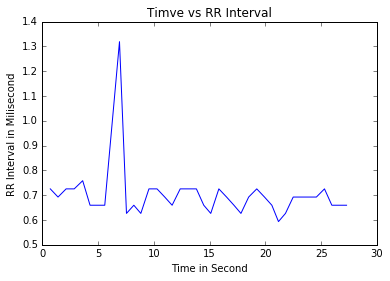

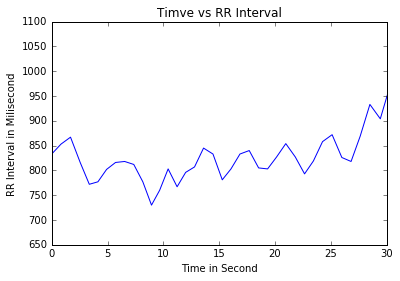

In [31]:
%matplotlib inline
l = analyzeVideoAndObtainBestRedRRInterval("/home/mong/Desktop/map/map/videos/VID_20150123_172926_F.mp4.txt")
plt.plot(constructTimeListFromRRInterval(l), l)
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.show()




plt.plot(ecg1.getTimeList(), ecg1.getRRITList())
plt.xlabel('Time in Second')
plt.ylabel('RR Interval in Milisecond')
plt.title('Timve vs RR Interval')
plt.xlim(0, 30)
plt.show()